In [1]:
import numpy as np
import sys
import os
import argparse
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.stats
import seaborn as sns

# latex rendering
# mpl.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 15.5
plt.rcParams['axes.labelsize'] = 15.5
plt.rcParams['xtick.labelsize'] = 15.5
plt.rcParams['ytick.labelsize'] = 15.5
plt.rcParams['legend.fontsize'] = 15.5

In [2]:
NaId = [1,376]
numNa = NaId[1] - NaId[0] + 1

SbId = [377,504]
numSb = SbId[1] - SbId[0] + 1

SeId = [505,1016]
numSe = SeId[1] - SeId[0] + 1

# degrees of freedom
dof = 3

In [3]:
# # simulation parameters
dt_sim = 0.002;
ss_per_ts = 1
delT = dt_sim * ss_per_ts;

t_tot = 15
total_ts = 7500
num_ss = t_tot / delT + 1
N_delt = int(t_tot / delT)

numAtoms = 1016

print("delT = ", delT)
print("N_delt = ", N_delt)

delT =  0.002
N_delt =  7500


In [4]:
trunc_err = '1e-6'
atom_label_lst = ['Na', 'Sb', 'Se']

#### gamma = 1e-5 ####
foldergamma = "1e-5"
numStiefelSamples = 1000
LFeps_Lst = ['1e-5']
labelLFeps_Lst = [r'$1e^{-5}$']
NrLF_Lst = [622]
NrHF_Lst = [361]

######################


# #### gamma = 0 ####
# foldergamma = "0"
# numStiefelSamples = 1000
# LFeps_Lst = ['1e-4', '1e-5']
# labelLFeps_Lst = [r'$1e^{-4}$', r'$1e^{-5}$']
# NrLF_Lst = [469, 606]
# NrHF_Lst = [315, 178]
# ######################

In [5]:
pot_label_lst = ['NEP', 'MLIP']
atom_label_lst = ['Na', 'Sb', 'Se']


############## load fom data ##############
root = os.getcwd()
folder = 'fom_data_15ps'

# load data
msd_data = {}
for pot_label in pot_label_lst:
    msd_data[pot_label] = {}
    for atom_label in atom_label_lst:
        msd_data[pot_label][atom_label] = np.loadtxt(f'{root}/{folder}/{pot_label}/compute_msd{atom_label}.txt')
        print(msd_data[pot_label][atom_label].shape)
###########################################

############## load ROM data ##############
ROM_MOM_folderdir = f"{root}/rom_data_15ps/ROM_NVT_{trunc_err}"
msd_data_ROM_ALL_lst = []
msd_data_ROM_Global_ALL_lst = []

# we first get the MOM data
for id_folder, folder_name in enumerate(LFeps_Lst):
    print("Current folder name: ", folder_name)
    # load data
    msd_data_ROM = {}
    msd_data_ROM_Global = {}

    for pot_label in pot_label_lst:
        msd_data_ROM[pot_label] = {}
        print("Current pot label: ", pot_label)
        for atom_label in atom_label_lst:
            # load text data, if null fill with 0
            print("Curr atom label: ", atom_label)
            # print(f'{ROM_MOM_folderdir}/gamma_{folder_name}/{pot_label}/msd{atom_label}.data')
            msd_data_npy = np.genfromtxt(f'{ROM_MOM_folderdir}/gamma_{foldergamma}/{pot_label}/compute_msd{atom_label}.txt', invalid_raise=False, filling_values=0)
            # print rows where the data is invalid
            # print("Invalid rows = ", np.where(msd_data_npy == 0))
            msd_data_ROM[pot_label][atom_label] = msd_data_npy
        print("#################")

    # load Global data
    for pot_label in pot_label_lst:
        msd_data_ROM_Global[pot_label] = {}
        print("Current Global pot label: ", pot_label)
        for atom_label in atom_label_lst:
            # load text data, if null fill with 0
            print("Curr atom label: ", atom_label)
            msd_data_Global_npy = np.genfromtxt(f'{ROM_MOM_folderdir}/gamma_{foldergamma}/Global/{pot_label}/compute_msd{atom_label}.txt', invalid_raise=False, filling_values=0)
            # print rows where the data is invalid
            # print("Invalid rows = ", np.where(msd_data_Global_npy == 0))
            msd_data_ROM_Global[pot_label][atom_label] = msd_data_Global_npy
        print("#################")

    # store the data
    msd_data_ROM_ALL_lst.append(msd_data_ROM)
    msd_data_ROM_Global_ALL_lst.append(msd_data_ROM_Global)
print("Number of MOM data collected: ", len(msd_data_ROM_ALL_lst))
print("Number of MOM Global data collected: ", len(msd_data_ROM_Global_ALL_lst))

# store the data
msd_data_ROM_ALL_lst.append(msd_data_ROM)
msd_data_ROM_Global_ALL_lst.append(msd_data_ROM_Global)

print("Number of all data collected: ", len(msd_data_ROM_ALL_lst))
print("Number of all Global data collected: ", len(msd_data_ROM_Global_ALL_lst))

(7501,)
(7501,)
(7501,)
(7501,)
(7501,)
(7501,)
Current folder name:  1e-5
Current pot label:  NEP
Curr atom label:  Na
Curr atom label:  Sb
Curr atom label:  Se
#################
Current pot label:  MLIP
Curr atom label:  Na
Curr atom label:  Sb
Curr atom label:  Se
#################
Current Global pot label:  NEP
Curr atom label:  Na
Curr atom label:  Sb
Curr atom label:  Se
#################
Current Global pot label:  MLIP
Curr atom label:  Na
Curr atom label:  Sb
Curr atom label:  Se
#################
Number of MOM data collected:  1
Number of MOM Global data collected:  1
Number of all data collected:  2
Number of all Global data collected:  2


In [6]:
# load stiefel samples
msd_data_samples_ALL = []
# load msd[atom_label] from every folder
for j in range(len(NrHF_Lst)):
    LFeps = LFeps_Lst[j]
    NrLF = NrLF_Lst[j]
    NrHF = NrHF_Lst[j]

    msd_data_samples = {}

    for atom_label in atom_label_lst:
        msd_data_samples[atom_label] = {}
        # qoiDir = f"{os.getcwd()}/Randomization_eps{trunc_err}_gam{foldergamma_Lst[0]}/localization/ROM_LFeps{LFeps}_NrLF{NrLF}_NrHF{NrHF}/multi-potential-{numStiefelSamples}"
        qoiDir = f"{os.getcwd()}/Rand15ps_eps{trunc_err}/gamma_{foldergamma}/localization/ROM_LFeps{LFeps}_NrLF{NrLF}_NrHF{NrHF}/multi-potential-{numStiefelSamples}"
        for i in range(numStiefelSamples):
            msd_data_samples[atom_label][i] = np.loadtxt(f'{qoiDir}/{i}/compute_msd{atom_label}.txt')
    print("msd_data_samples keys: ", msd_data_samples.keys())
    print(len(msd_data_samples['Na'].keys()))

    msd_data_samples_ALL.append(msd_data_samples)

msd_data_samples keys:  dict_keys(['Na', 'Sb', 'Se'])
1000


## Calculate the diffusitivity of the Na atom for NEP

In [7]:
# truncate the data to start from 2 ps
X_t_start = 1
msd_trunc_start = X_t_start / delT
print("msd_trunc_start = ", msd_trunc_start)
msd_trunc_start = int(msd_trunc_start)

X_t_end = 11
msd_trunc_end = X_t_end / delT
print("msd_trunc_end = ", msd_trunc_end)
msd_trunc_end = int(msd_trunc_end)

msd_data_Na_Xtps_ALL = []
for id_msd, msd_data_samples in enumerate(msd_data_samples_ALL):
    msd_data_Na_Xtps = []
    for id, pot_type in enumerate(pot_label_lst):
        # truncate the data to start from 0.3 ps
        msd_data_Na_Xtps.append(msd_data[pot_type]['Na'][msd_trunc_start:msd_trunc_end])
        print("msd_data_Na_2ps[", id, "] = ", msd_data_Na_Xtps[id].shape)
    msd_data_Na_Xtps_ALL.append(msd_data_Na_Xtps)

msd_trunc_start =  500.0
msd_trunc_end =  5500.0
msd_data_Na_2ps[ 0 ] =  (5000,)
msd_data_Na_2ps[ 1 ] =  (5000,)


<>:57: SyntaxWarning: invalid escape sequence '\A'
<>:57: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_560331/1055100005.py:57: SyntaxWarning: invalid escape sequence '\A'
  ax.plot(time, slope*time + intercept, color='gray', linestyle='--', linewidth=0.8, alpha=0.4, label=f'Sample {i} fit; D = {D:.4f} $\AA^2$/ps')


total number of samples before adding FOM data=  1
total number of samples after adding FOM data =  3


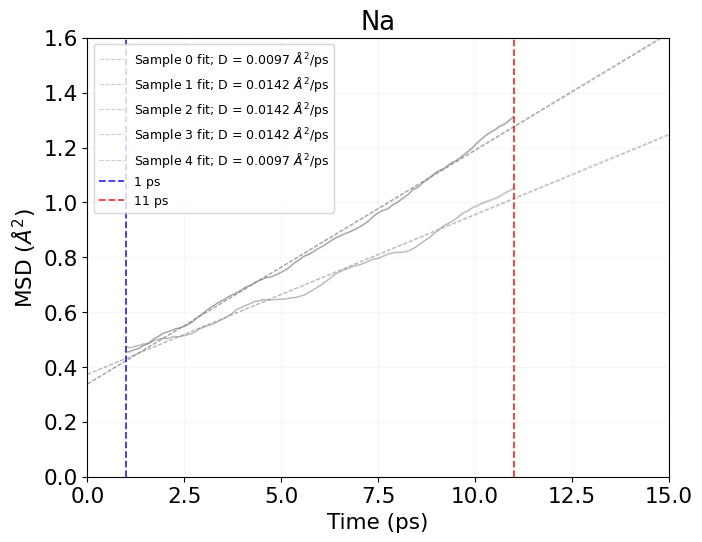

In [8]:
# now lets find the slope for all samples
time = np.linspace(0, t_tot, N_delt + 1)

# print("time = ", time.shape)
msd_slope_AA2perps_samples_Lst = []
D_cm2persec_samples_Lst = []
for j in range(len(NrHF_Lst)):
    msd_data_samples = msd_data_samples_ALL[j]
    msd_slope_AA2perps_samples = []
    D_cm2persec_samples = []
    for i in range(numStiefelSamples):
        # fit the data to a line
        # print("Sample ", i, "shape = ", msd_data_samples["Na"][i][:, -1][:numSS_15ps].shape)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(time[msd_trunc_start:msd_trunc_end], msd_data_samples["Na"][i][msd_trunc_start:msd_trunc_end])
        # print("slope = ", slope)
        D = slope / 6
        msd_slope_AA2perps_samples.append([slope, intercept, D])
        D_cm2persec_samples.append(D * 1e-4)
    msd_slope_AA2perps_samples_Lst.append(msd_slope_AA2perps_samples)
    D_cm2persec_samples_Lst.append(D_cm2persec_samples)
print("total number of samples before adding FOM data= ", len(D_cm2persec_samples_Lst))

# fom data
for pot_id, pot_type in enumerate(pot_label_lst):
    msd_data_Na_Xtps = msd_data[pot_type]['Na'][msd_trunc_start:msd_trunc_end]
    # fit the data to a line
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(time[msd_trunc_start:msd_trunc_end], msd_data_Na_Xtps)
    D = slope / 6
    msd_slope_AA2perps_samples_Lst.append([slope, intercept, D])
    D_cm2persec_samples_Lst.append(D * 1e-4)

print("total number of samples after adding FOM data = ", len(D_cm2persec_samples_Lst))

############# plot msd and slope for Na #############
# plot msd for Na
fig, ax = plt.subplots(1, 1, figsize=(5*1.5, 3.8*1.5))
for i in range(5):
    # plot msd for Na
    # print("time = ", time.shape)
    ax.plot(time[msd_trunc_start:msd_trunc_end], msd_data_samples["Na"][i][msd_trunc_start:msd_trunc_end], linewidth=0.8, alpha=0.4, color='gray')
    ax.set_xlabel('Time (ps)')
    ax.set_title(f'Na')
    ax.set_ylabel(r'MSD ($\AA^2$)')
    # set y axis limit
    ax.set_ylim([0, 1.6])
    # set x axis limit
    ax.set_xlim([0.3, 15])
    # add ticks of 5
    ax.set_xticks(np.arange(0, 16, 2.5))
    # add grid
    ax.grid(True, alpha=0.1)

    slope = msd_slope_AA2perps_samples[i][0]
    intercept = msd_slope_AA2perps_samples[i][1]
    D = msd_slope_AA2perps_samples[i][2]
    # plot the linear fit
    ax.plot(time, slope*time + intercept, color='gray', linestyle='--', linewidth=0.8, alpha=0.4, label=f'Sample {i} fit; D = {D:.4f} $\AA^2$/ps')

# draw a vertical line at 0.3 ps
ax.axvline(x=X_t_start, color='b', linestyle='--', linewidth=1.3, alpha=0.8, label=f'{X_t_start} ps')
ax.axvline(x=X_t_end, color='r', linestyle='--', linewidth=1.3, alpha=0.8, label=f'{X_t_end} ps')

# Add the legend to the first subplot
ax.legend(loc='best', fontsize=9)

NEP D =  1.4373927675734279e-06
MLIP D =  9.820830135677458e-07


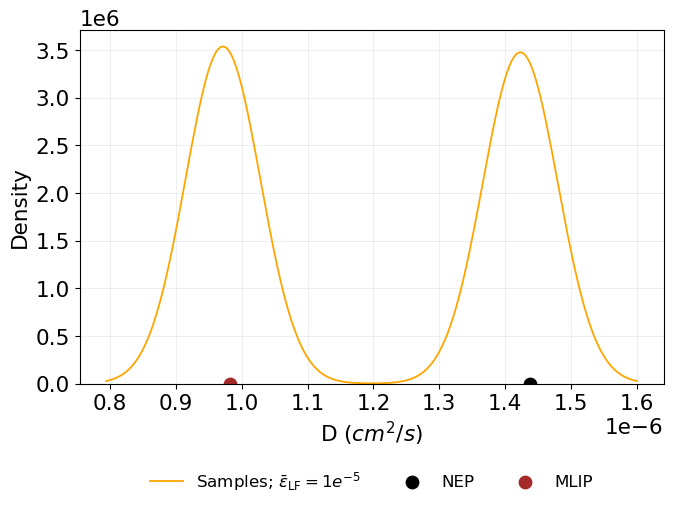

In [17]:
# Plot the distribution of D
fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

samples_color = ['orange', 'green']

# Plot the kde of D
for j in range(len(NrHF_Lst)):
    D_cm2persec_samples = D_cm2persec_samples_Lst[j]
    sns.kdeplot(D_cm2persec_samples[:numStiefelSamples], color=samples_color[j], label=f'Samples; $\\bar\\epsilon_{{\\text{{LF}}}}=${labelLFeps_Lst[j]}', linewidth=1.3)

# Fom data plot as marker
colors = ['k', 'brown']
for pot_id, pot_type in enumerate(pot_label_lst):
    D = D_cm2persec_samples_Lst[pot_id-2]
    print(f'{pot_type} D = ', D)
    ax.scatter(D, 0, color=colors[pot_id], label=f'{pot_type}', marker='o', s=80)

# Labels
ax.set_xlabel('D ($cm^2/s$)')
ax.set_ylabel('Density')
# set x limit
# ax.set_xlim([0.5 * 1e-6, 1.6 * 1e-6])
# Grid
ax.grid(True, alpha=0.2)
# Legend at the bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=12, frameon=False)
# Save the figure
plt.tight_layout()

In [37]:
print(root)

/data1/yq87/CRISPS/Na3SbSe4-May62024/SIM_15ps_ALLSS


len(D_cm2persec_samples_Lst) =  3
NEP D =  1.4373927675734279e-06
MLIP D =  9.820830135677458e-07


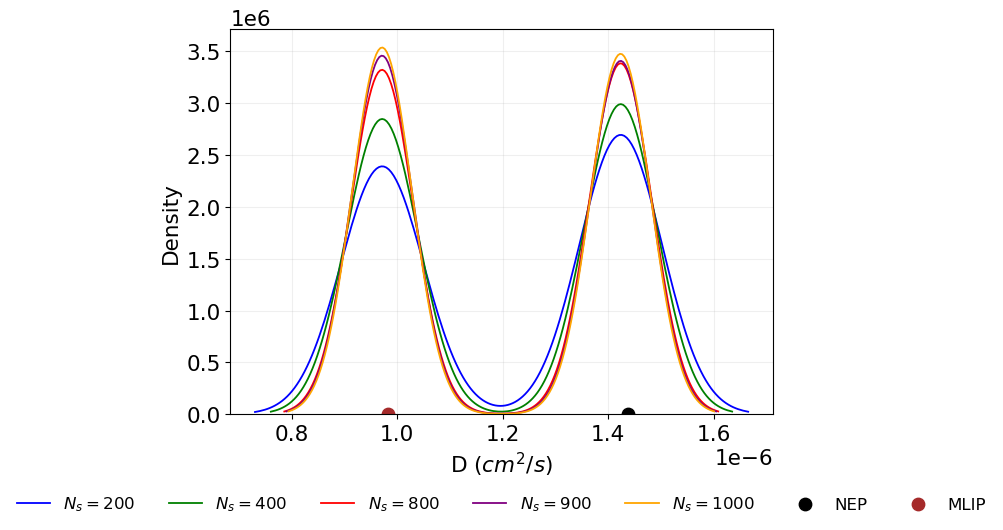

In [41]:
# to test convergence, plot numSamplesTest = [200, 500, 1000]
numSamplesTestLst = [200, 400, 800, 900, 1000]
colorLst = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
randomSeed = 32

# number of datasets # (the last 2 sets are FOM data)
print("len(D_cm2persec_samples_Lst) = ", len(D_cm2persec_samples_Lst))
    
# Plot kde of D with different number of samples
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the kde of D
for set_id, numSampleTest in enumerate(numSamplesTestLst):
    # generate Random Indices for the samples
    np.random.seed(randomSeed)
    randomIndices = np.random.choice(numStiefelSamples, numSampleTest, replace=False)
    D_cm2persec_samples = D_cm2persec_samples_Lst[0]
    sns.kdeplot(np.array(D_cm2persec_samples)[randomIndices], color=colorLst[set_id], label=f'$N_s=${numSampleTest}', linewidth=1.3)

# Fom data plot as marker
colors = ['k', 'brown']
for pot_id, pot_type in enumerate(pot_label_lst):
    D = D_cm2persec_samples_Lst[pot_id-2]
    print(f'{pot_type} D = ', D)
    ax.scatter(D, 0, color=colors[pot_id], label=f'{pot_type}', marker='o', s=80)

# Labels
ax.set_xlabel('D ($cm^2/s$)')
ax.set_ylabel('Density')
# set x limit
# ax.set_xlim([0.5 * 1e-6, 1.6 * 1e-6])
# Grid
ax.grid(True, alpha=0.2)
# Legend at the bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), ncol=7, fontsize=12, frameon=False)
# Save the figure
# plt.tight_layout()
plt.savefig(f'{root}/Rand15ps_eps{trunc_err}/gamma_{foldergamma}/figs/DConvergenceLFeps{LFeps_Lst[0]}.png', dpi=300, bbox_inches='tight')